## EDA

- Google Books (API) — 1733 записей
- Project Gutenberg (скрапинг) — 10000 записей

## Бизнес-задача

**Предсказание полноты метаданных книги для автоматизации процесса обогащения каталога.**

Онлайн-библиотека или книжный магазин получает данные о книгах из разных источников. Часть книг имеет полную информацию (описание, категории, издатель, год), а часть — только базовые данные (название, автор). Задача автоматически определять книги с неполными метаданными, чтобы приоритизировать их для ручного обогащения, выявить закономерности в полноте данных, и оптимизировать процесс интеграции новых источников данных

**Целевая переменная**: `metadata_completeness` (complete / incomplete)
- **complete**: книга имеет 3+ из 4 ключевых полей (описание, категории, издатель, год)
- **incomplete**: книга имеет менее 3 полей

## 1. Импорт библиотек и загрузка данных

In [27]:
import sys
import re
from collections import Counter
from pathlib import Path
import config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
sys.path.append(str(Path.cwd().parent))

df = pd.read_csv(config.DATA_DIR / 'cleaned_books.csv')
print(f"Загружено записей: {len(df)}")
print(f"Колонок: {len(df.columns)}")
print(f"Колонки: {df.columns.tolist()}")


Загружено записей: 11733
Колонок: 16
Колонки: ['id', 'title', 'author', 'publisher', 'published_date', 'description', 'categories', 'language', 'page_count', 'average_rating', 'ratings_count', 'thumbnail', 'source', 'detail_link', 'year', 'metadata_completeness']


## 2. Первичный обзор данных

In [28]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11733 entries, 0 to 11732
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1733 non-null   object 
 1   title                  11732 non-null  object 
 2   author                 11013 non-null  object 
 3   publisher              757 non-null    object 
 4   published_date         1709 non-null   object 
 5   description            946 non-null    object 
 6   categories             1364 non-null   object 
 7   language               1733 non-null   object 
 8   page_count             1681 non-null   float64
 9   average_rating         52 non-null     float64
 10  ratings_count          44 non-null     float64
 11  thumbnail              1643 non-null   object 
 12  source                 11733 non-null  object 
 13  detail_link            10000 non-null  object 
 14  year                   1530 non-null   float64
 15  me

In [29]:
df.head(10)


,id,title,author,publisher,published_date,description,categories,language,page_count,average_rating,ratings_count,thumbnail,source,detail_link,year,metadata_completeness
0,XG--8X3YDs4C,The Columbia Guide to Contemporary African Ame...,Darryl Dickson-Carr,Columbia University Press,2005-10-14,From Ishmael Reed and Toni Morrison to Colson ...,Literary Collections,en,292.0,NaN,NaN,http://books.google.com/books/content?id=XG--8...,google_books_api,NaN,2005.0,complete
1,uVw-SnIn8dgC,Sciencefiction Collections,Halbert W. Hall,Psychology Press,1983,ScienceFiction Collections offers different vi...,Fiction,en,194.0,NaN,NaN,http://books.google.com/books/content?id=uVw-S...,google_books_api,NaN,1983.0,complete
2,WmKYoVsTxroC,Major Trends in the Post-independence Indian E...,"B. R. Agrawal, M. P. Sinha",Atlantic Publishers & Dist,2003,This Book Presents A Reasonably Comprehensive ...,Indic fiction (English),en,300.0,NaN,NaN,http://books.google.com/books/content?id=WmKYo...,google_books_api,NaN,2003.0,complete
3,FHjheL8OXtUC,Crime Fiction,John Scaggs,Psychology Press,2005,Provides a lively introduction to what is both...,Fiction,en,192.0,NaN,NaN,http://books.google.com/books/content?id=FHjhe...,google_books_api,NaN,2005.0,complete
4,UgZsi_DOKoQC,Fan Fiction and Fan Communities in the Age of ...,"Karen Hellekson, Kristina Busse",McFarland,2014-09-17,Fans have been responding to literary works si...,Literary Criticism,en,297.0,NaN,NaN,http://books.google.com/books/content?id=UgZsi...,google_books_api,NaN,2014.0,complete
5,5Zpq0Rmm7hQC,The Distinction of Fiction,Dorrit Cohn,JHU Press,2000-12,Winner of the Aldo and Jeanne Scaglione Prize ...,Literary Criticism,en,214.0,NaN,NaN,http://books.google.com/books/content?id=5Zpq0...,google_books_api,NaN,2000.0,complete
6,-8iD6iuO-iAC,New Boundaries in Political Science Fiction,"Donald M. Hassler, Clyde Wilcox",Univ of South Carolina Press,2008,This book offers an interpretation of the evol...,Literary Criticism,en,382.0,NaN,NaN,http://books.google.com/books/content?id=-8iD6...,google_books_api,NaN,2008.0,complete
7,xq-jDAAAQBAJ,Fantasy and Science Fiction,Кулинцева Н. А.,Directmedia,2016-04-22,Настоящее издание является учебным пособием по...,NaN,ru,174.0,NaN,NaN,http://books.google.com/books/content?id=xq-jD...,google_books_api,NaN,2016.0,complete
8,lALGYRHmqycC,A Geography of Victorian Gothic Fiction,Robert Mighall,OUP Oxford,2003,This is the first major full-length study of V...,History,en,344.0,NaN,NaN,http://books.google.com/books/content?id=lALGY...,google_books_api,NaN,2003.0,complete
9,rRhNEQAAQBAJ,Как написать и издать самому книгу non-fiction,Серафима Суворова,ЛитРес,2025-03-06,Как написать и издать самому книгу non-fiction...,Reference,ru,28.0,NaN,NaN,http://books.google.com/books/content?id=rRhNE...,google_books_api,NaN,2025.0,complete


In [30]:
df.describe()


,page_count,average_rating,ratings_count,year
count,1681.000000,52.000000,44.0,1530.000000
mean,414.703748,4.326923,1.0,1986.677124
std,309.274033,1.075050,0.0,39.276222
min,0.000000,1.000000,1.0,1900.000000
25%,215.000000,4.000000,1.0,1959.250000
50%,327.000000,5.000000,1.0,2005.000000
75%,552.000000,5.000000,1.0,2019.000000
max,1586.000000,5.000000,1.0,2026.000000


## 3. Анализ пропущенных значений

In [31]:
print("Гипотезы о пропущенных значениях:\n")

if 'description' in df.columns:
    desc_missing = df['description'].isnull().sum()
    desc_pct = (desc_missing / len(df)) * 100
    print(f"1. description ({desc_pct:.1f}% пропущено):")
    print("   Гипотеза: Описания отсутствуют в основном у книг из Project Gutenberg,")
    print("   так как этот источник предоставляет только базовую информацию.")
    if 'source' in df.columns:
        desc_by_source = df.groupby('source')['description'].apply(lambda x: x.isnull().sum())
        print(f"   Проверка: Пропуски по источникам:")
        for source, count in desc_by_source.items():
            total = len(df[df['source'] == source])
            print(f"     {source}: {count} из {total} ({count/total*100:.1f}%)")

if 'average_rating' in df.columns:
    rating_missing = df['average_rating'].isnull().sum()
    rating_pct = (rating_missing / len(df)) * 100
    print(f"\n2. average_rating ({rating_pct:.1f}% пропущено):")
    print("   Гипотеза: Рейтинги доступны только для книг из Google Books API,")
    print("   так как Project Gutenberg не предоставляет рейтинги.")
    if 'source' in df.columns:
        rating_by_source = df.groupby('source')['average_rating'].apply(lambda x: x.notna().sum())
        print(f"   Проверка: Наличие рейтингов по источникам:")
        for source, count in rating_by_source.items():
            total = len(df[df['source'] == source])
            print(f"     {source}: {count} из {total} ({count/total*100:.1f}%)")

if 'publisher' in df.columns:
    pub_missing = df['publisher'].isnull().sum()
    pub_pct = (pub_missing / len(df)) * 100
    print(f"\n3. publisher ({pub_pct:.1f}% пропущено):")
    print("   Гипотеза: Издатель отсутствует для старых книг из Project Gutenberg,")
    print("   так как информация об издателе может быть недоступна для классических произведений.")

if 'year' in df.columns:
    year_missing = df['year'].isnull().sum()
    year_pct = (year_missing / len(df)) * 100
    print(f"\n4. year ({year_pct:.1f}% пропущено):")
    print("   Гипотеза: Год публикации отсутствует, если дата в нестандартном формате")
    print("   или если книга очень старая и точная дата неизвестна.")


Гипотезы о пропущенных значениях:

1. description (91.9% пропущено):
   Гипотеза: Описания отсутствуют в основном у книг из Project Gutenberg,
   так как этот источник предоставляет только базовую информацию.
   Проверка: Пропуски по источникам:
     google_books_api: 787 из 1733 (45.4%)
     project_gutenberg: 10000 из 10000 (100.0%)

2. average_rating (99.6% пропущено):
   Гипотеза: Рейтинги доступны только для книг из Google Books API,
   так как Project Gutenberg не предоставляет рейтинги.
   Проверка: Наличие рейтингов по источникам:
     google_books_api: 52 из 1733 (3.0%)
     project_gutenberg: 0 из 10000 (0.0%)

3. publisher (93.5% пропущено):
   Гипотеза: Издатель отсутствует для старых книг из Project Gutenberg,
   так как информация об издателе может быть недоступна для классических произведений.

4. year (87.0% пропущено):
   Гипотеза: Год публикации отсутствует, если дата в нестандартном формате
   или если книга очень старая и точная дата неизвестна.


Пропущенные значения:
                Пропущено    Процент
ratings_count       11689  99.624989
average_rating      11681  99.556806
publisher           10976  93.548112
description         10787  91.937271
categories          10369  88.374670
year                10203  86.959857
thumbnail           10090  85.996761
page_count          10052  85.672888
published_date      10024  85.434245
id                  10000  85.229694
language            10000  85.229694
detail_link          1733  14.770306
author                720   6.136538
title                   1   0.008523

Общая разреженность датасета: 63.03%
Всего пропущенных значений: 118325 из 187728


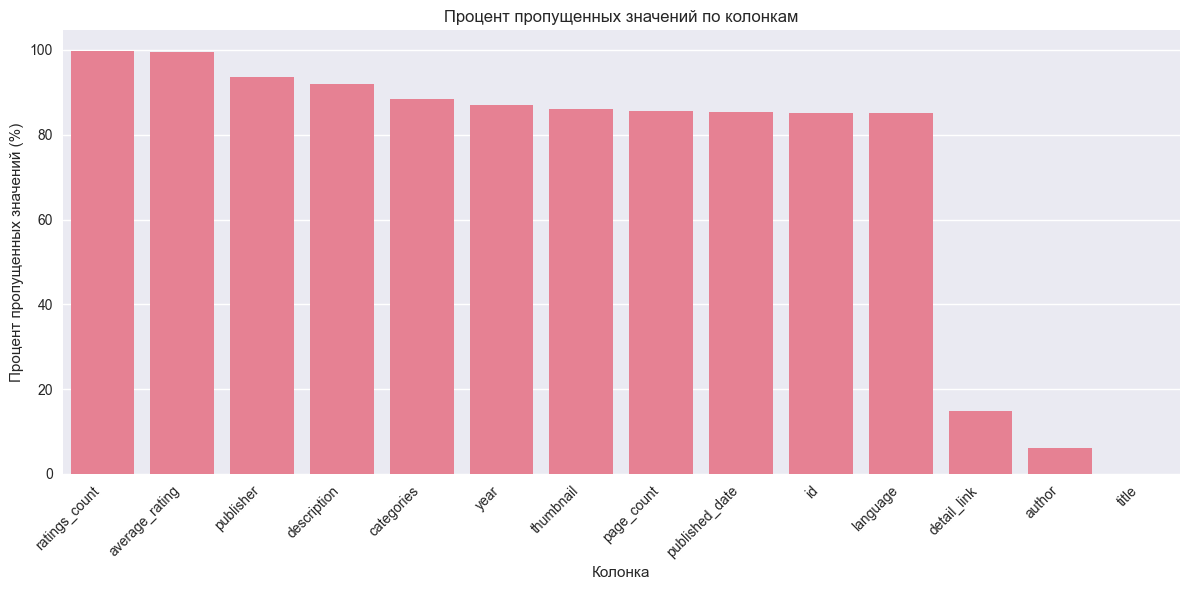

In [32]:
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Пропущено': missing,
    'Процент': missing_percent
})
missing_df = missing_df[missing_df['Пропущено'] > 0].sort_values('Пропущено', ascending=False)
print("Пропущенные значения:")
print(missing_df)

total_missing = df.isnull().sum().sum()
total_cells = len(df) * len(df.columns)
sparsity = (total_missing / total_cells) * 100
print(f"\nОбщая разреженность датасета: {sparsity:.2f}%")
print(f"Всего пропущенных значений: {total_missing} из {total_cells}")

if len(missing_df) > 0:
    plt.figure(figsize=(12, 6))
    sns.barplot(data=missing_df.reset_index(), x='index', y='Процент')
    plt.title('Процент пропущенных значений по колонкам')
    plt.xlabel('Колонка')
    plt.ylabel('Процент пропущенных значений (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


## 4. Анализ ошибочных значений

In [33]:
print("Проверка ошибочных значений:\n")

if 'average_rating' in df.columns:
    invalid_ratings = df[(df['average_rating'] < 0) | (df['average_rating'] > 5)]
    print(f"1. average_rating:")
    print(f"   Рейтинги вне диапазона [0, 5]: {len(invalid_ratings)} записей")
    if len(invalid_ratings) > 0:
        print(f"   Примеры: {invalid_ratings[['title', 'average_rating']].head()}")

if 'ratings_count' in df.columns:
    invalid_counts = df[df['ratings_count'] < 0]
    print(f"\n2. ratings_count:")
    print(f"   Отрицательные значения: {len(invalid_counts)} записей")

if 'page_count' in df.columns:
    invalid_pages = df[df['page_count'] < 0]
    print(f"\n3. page_count:")
    print(f"   Отрицательные значения: {len(invalid_pages)} записей")
    zero_pages = df[df['page_count'] == 0]
    if len(zero_pages) > 0:
        print(f"   Нулевые значения: {len(zero_pages)} записей")

if 'year' in df.columns:
    current_year = 2024
    future_years = df[df['year'] > current_year]
    very_old = df[df['year'] < 1000]
    print(f"\n4. year:")
    print(f"   Годы в будущем (> {current_year}): {len(future_years)} записей")
    print(f"   Очень старые годы (< 1000): {len(very_old)} записей")

print("\nВывод: Ошибочные значения были обработаны на этапе очистки данных.")


Проверка ошибочных значений:

1. average_rating:
   Рейтинги вне диапазона [0, 5]: 0 записей

2. ratings_count:
   Отрицательные значения: 0 записей

3. page_count:
   Отрицательные значения: 0 записей
   Нулевые значения: 68 записей

4. year:
   Годы в будущем (> 2024): 60 записей
   Очень старые годы (< 1000): 0 записей

Вывод: Ошибочные значения были обработаны на этапе очистки данных.


## 5. Анализ выбросов

Анализ выбросов (метод IQR с коэффициентом 3):
       Колонка  Выбросов  Процент  Нижняя граница  Верхняя граница
    page_count         3 0.178465          -796.0          1563.00
average_rating         0 0.000000             1.0             8.00
 ratings_count         0 0.000000             1.0             1.00
          year         0 0.000000          1780.0          2198.25


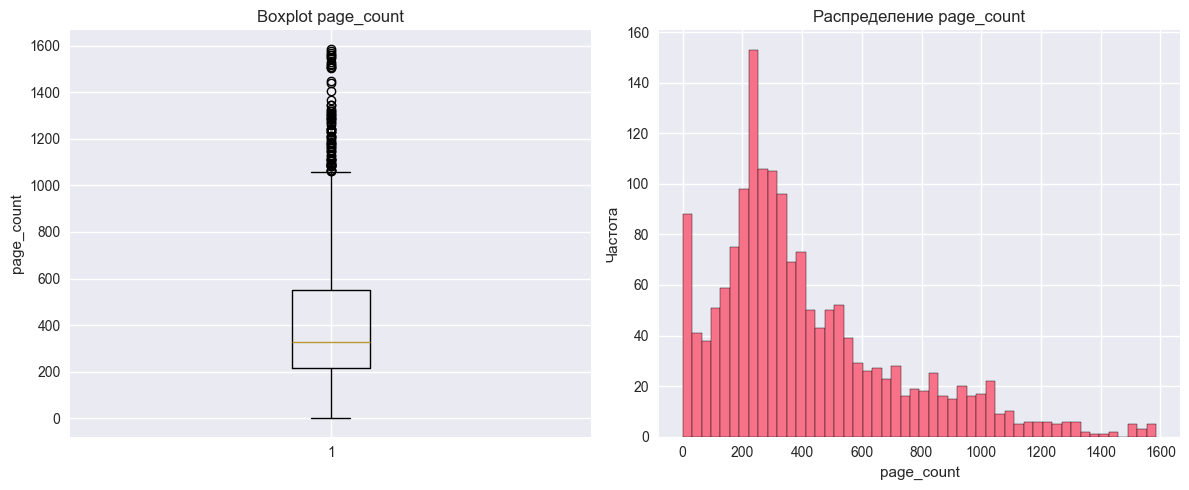

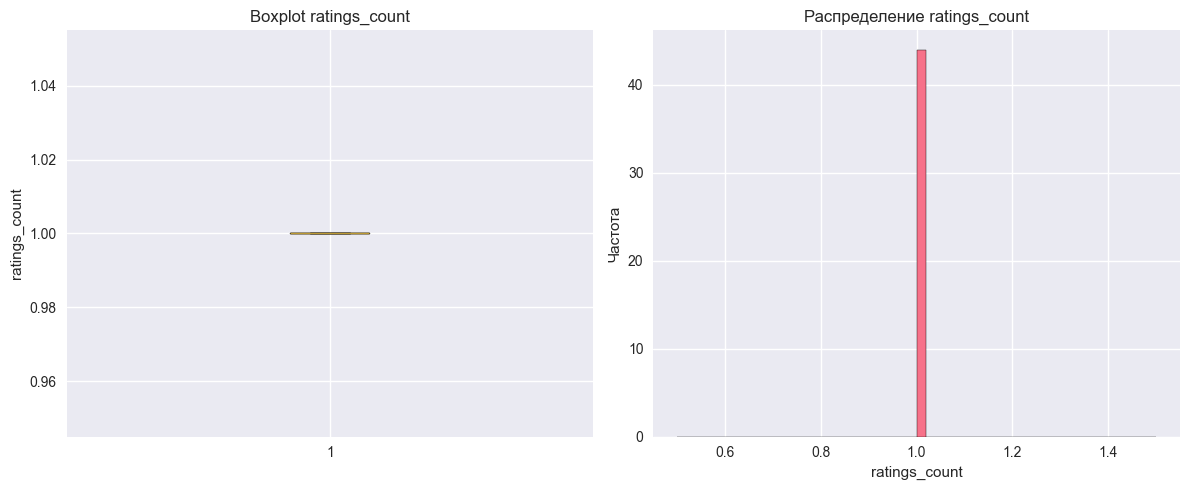


Примечание: Выбросы были обработаны на этапе очистки данных (заменены на NaN).


In [34]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
outlier_summary = []

for col in numeric_cols:
    if col in ['page_count', 'average_rating', 'ratings_count', 'year']:
        data = df[col].dropna()
        if len(data) > 0:
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 3 * IQR
            upper_bound = Q3 + 3 * IQR
            outliers = data[(data < lower_bound) | (data > upper_bound)]
            outlier_summary.append({
                'Колонка': col,
                'Выбросов': len(outliers),
                'Процент': len(outliers) / len(data) * 100,
                'Нижняя граница': lower_bound,
                'Верхняя граница': upper_bound
            })

if outlier_summary:
    outlier_df = pd.DataFrame(outlier_summary)
    print("Анализ выбросов (метод IQR с коэффициентом 3):")
    print(outlier_df.to_string(index=False))
    
    for col in ['page_count', 'ratings_count']:
        if col in df.columns:
            data = df[col].dropna()
            if len(data) > 0:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.boxplot(data)
                plt.title(f'Boxplot {col}')
                plt.ylabel(col)
                
                plt.subplot(1, 2, 2)
                plt.hist(data, bins=50, edgecolor='black')
                plt.title(f'Распределение {col}')
                plt.xlabel(col)
                plt.ylabel('Частота')
                plt.tight_layout()
                plt.show()

print("\nПримечание: Выбросы были обработаны на этапе очистки данных (заменены на NaN).")


## 6. Анализ распределений числовых переменных

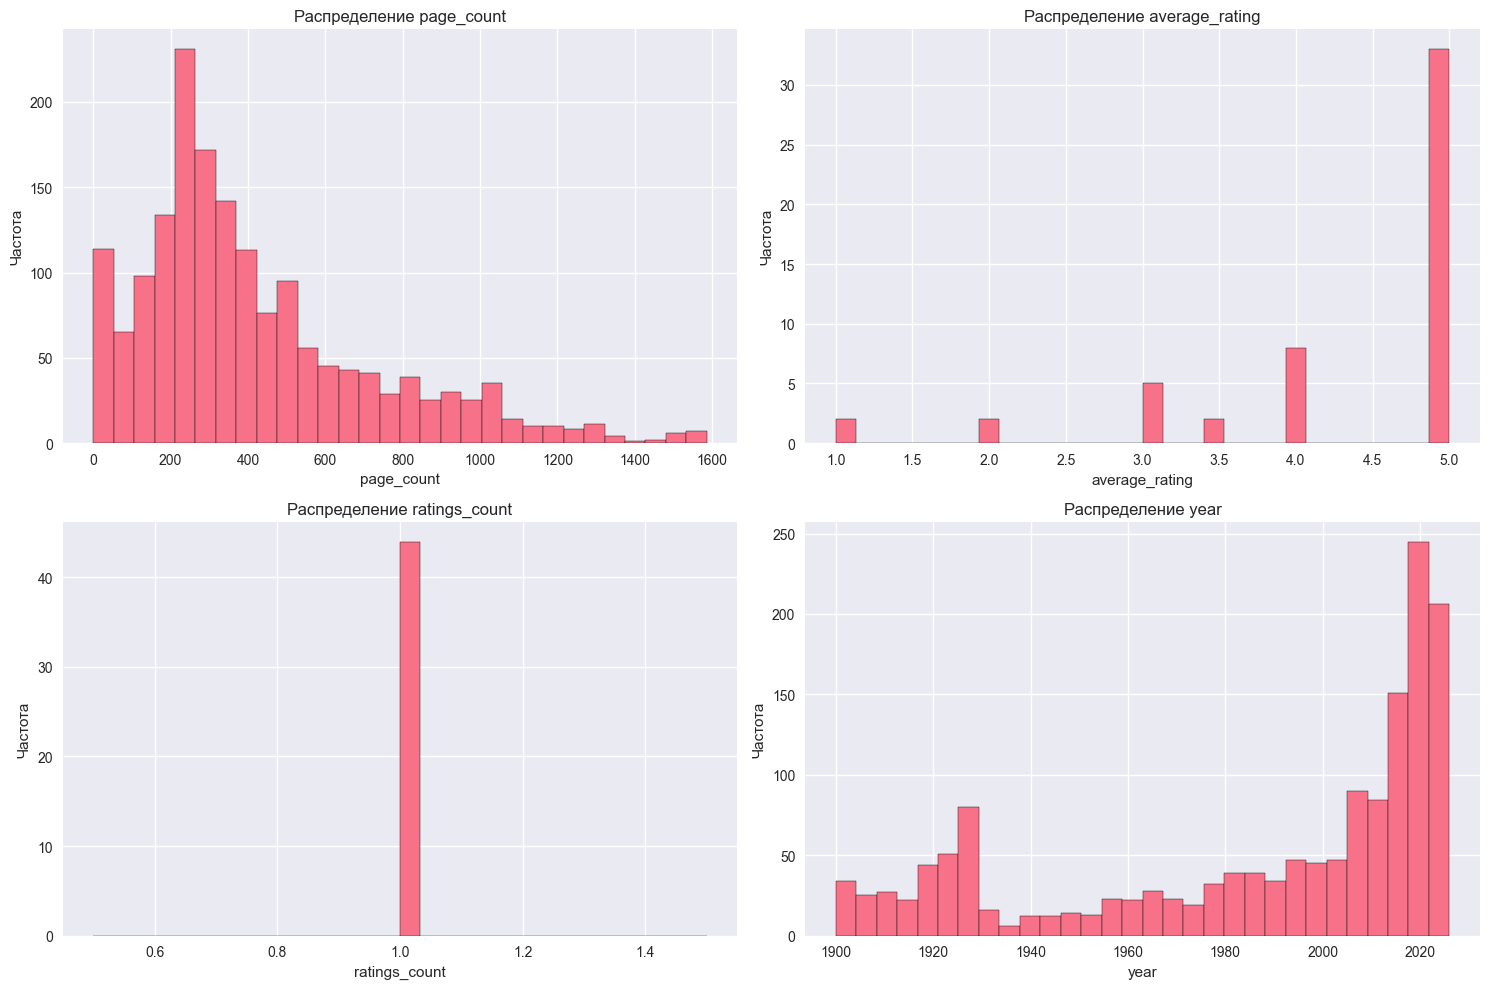


page_count:
  Среднее: 414.70
  Медиана: 327.00
  Стд. отклонение: 309.27
  Мин/Макс: 0.00 / 1586.00

average_rating:
  Среднее: 4.33
  Медиана: 5.00
  Стд. отклонение: 1.08
  Мин/Макс: 1.00 / 5.00

ratings_count:
  Среднее: 1.00
  Медиана: 1.00
  Стд. отклонение: 0.00
  Мин/Макс: 1.00 / 1.00

year:
  Среднее: 1986.68
  Медиана: 2005.00
  Стд. отклонение: 39.28
  Мин/Макс: 1900.00 / 2026.00


In [35]:
numeric_cols = ['page_count', 'average_rating', 'ratings_count', 'year']
available_cols = [col for col in numeric_cols if col in df.columns]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(available_cols[:4]):
    data = df[col].dropna()
    if len(data) > 0:
        axes[idx].hist(data, bins=30, edgecolor='black')
        axes[idx].set_title(f'Распределение {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Частота')

plt.tight_layout()
plt.show()

for col in available_cols:
    data = df[col].dropna()
    if len(data) > 0:
        print(f"\n{col}:")
        print(f"  Среднее: {data.mean():.2f}")
        print(f"  Медиана: {data.median():.2f}")
        print(f"  Стд. отклонение: {data.std():.2f}")
        print(f"  Мин/Макс: {data.min():.2f} / {data.max():.2f}")


## 7. Анализ связи признаков с целевой переменной

Анализ связи признаков с целевой переменной: average_rating


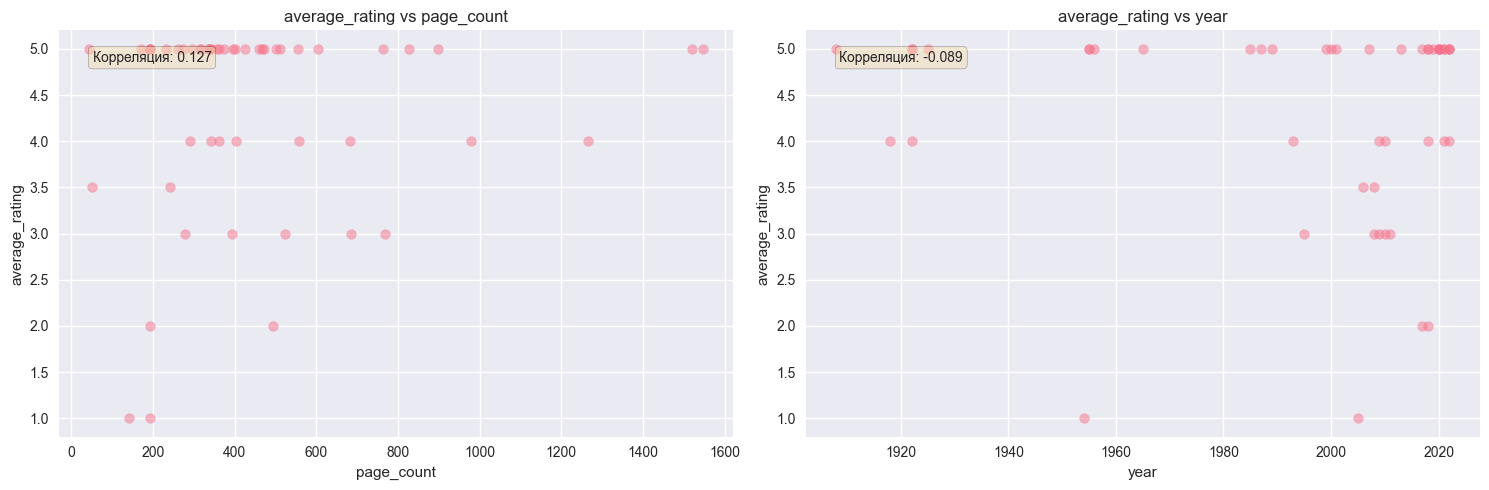


Корреляции с average_rating:
  page_count: 0.127
  year: -0.089

Среднее значение average_rating по источникам:
                      mean  median  count
source                                   
google_books_api  4.326923     5.0     52
Анализ связи признаков с целевой переменной: ratings_count


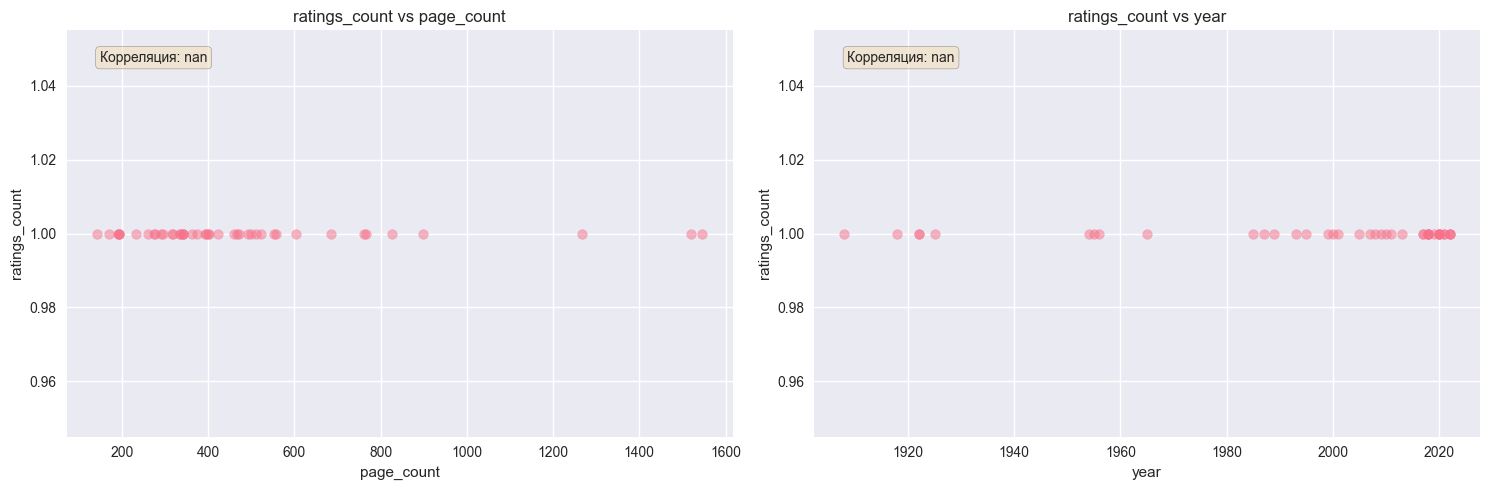


Корреляции с ratings_count:

Среднее значение ratings_count по источникам:
                  mean  median  count
source                               
google_books_api   1.0     1.0     44


In [36]:
target_vars = []
if 'average_rating' in df.columns:
    target_vars.append('average_rating')
if 'ratings_count' in df.columns:
    target_vars.append('ratings_count')

if target_vars:
    for target in target_vars:
        target_data = df[df[target].notna()]
        if len(target_data) > 0:
            print(f"Анализ связи признаков с целевой переменной: {target}")
            
            features = ['page_count', 'year']
            available_features = [f for f in features if f in df.columns]
            
            fig, axes = plt.subplots(1, len(available_features), figsize=(15, 5))
            if len(available_features) == 1:
                axes = [axes]
            
            for idx, feature in enumerate(available_features):
                feature_data = target_data[target_data[feature].notna()]
                if len(feature_data) > 0:
                    axes[idx].scatter(feature_data[feature], feature_data[target], alpha=0.5)
                    axes[idx].set_xlabel(feature)
                    axes[idx].set_ylabel(target)
                    axes[idx].set_title(f'{target} vs {feature}')
                    
                    corr = feature_data[feature].corr(feature_data[target])
                    axes[idx].text(0.05, 0.95, f'Корреляция: {corr:.3f}', 
                                  transform=axes[idx].transAxes, 
                                  verticalalignment='top',
                                  bbox=dict[str, str | float](boxstyle='round', facecolor='wheat', alpha=0.5))
            
            plt.tight_layout()
            plt.show()
            
            print(f"\nКорреляции с {target}:")
            numeric_features = target_data.select_dtypes(include=[np.number]).columns.tolist()
            numeric_features = [f for f in numeric_features if f != target]
            for feature in numeric_features:
                if feature in target_data.columns:
                    corr = target_data[feature].corr(target_data[target])
                    if not np.isnan(corr):
                        print(f"  {feature}: {corr:.3f}")
            
            if 'source' in df.columns:
                print(f"\nСреднее значение {target} по источникам:")
                source_stats = target_data.groupby('source')[target].agg(['mean', 'median', 'count'])
                print(source_stats)
else:
    print("Целевые переменные (average_rating, ratings_count) отсутствуют или полностью пропущены.")


## 8. Корреляционный анализ

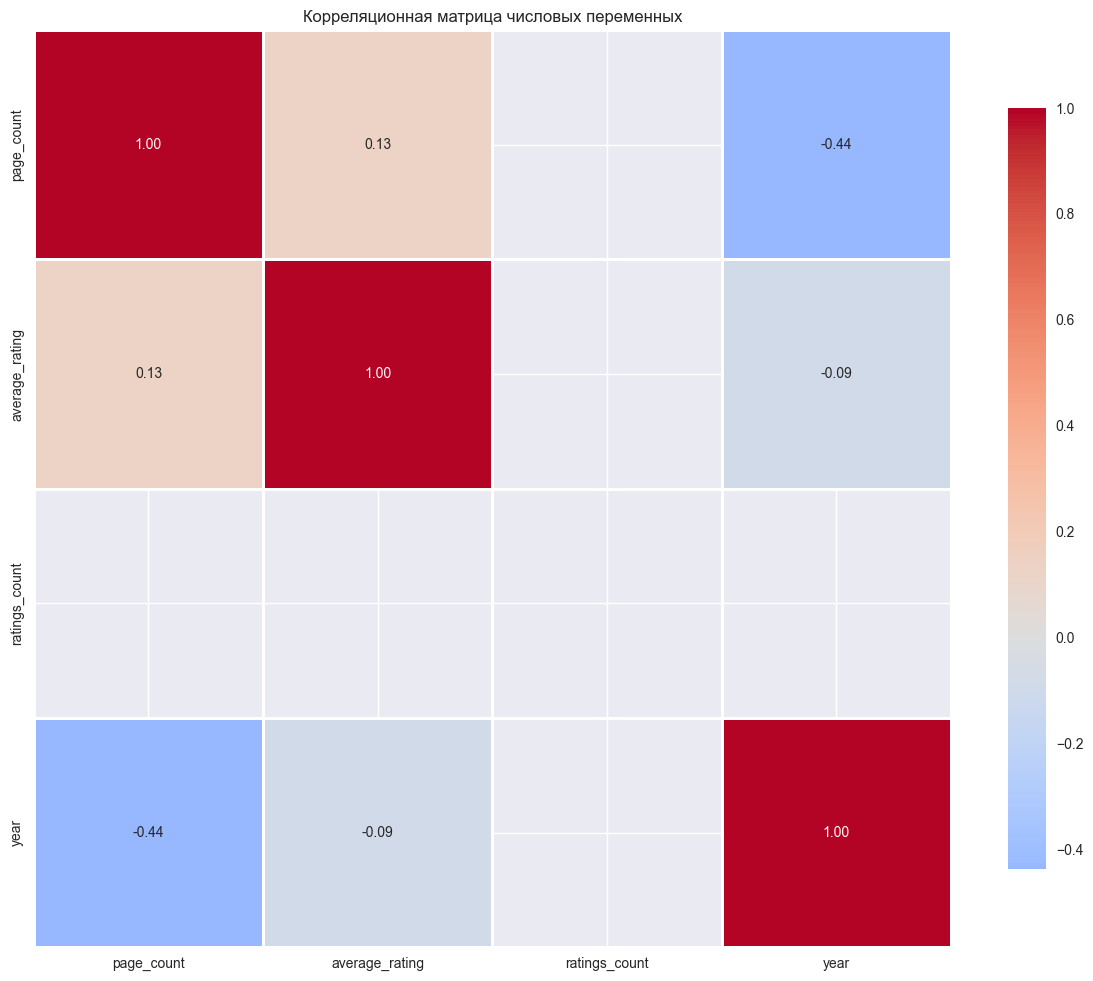


Наиболее значимые корреляции:
  page_count ↔ year: -0.439


In [37]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(numeric_cols) > 1:
    corr_matrix = df[numeric_cols].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Корреляционная матрица числовых переменных')
    plt.tight_layout()
    plt.show()
    
    print("\nНаиболее значимые корреляции:")
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > 0.3:
                print(f"  {corr_matrix.columns[i]} ↔ {corr_matrix.columns[j]}: {corr_val:.3f}")


## 9. Визуализация попарных распределений признаков

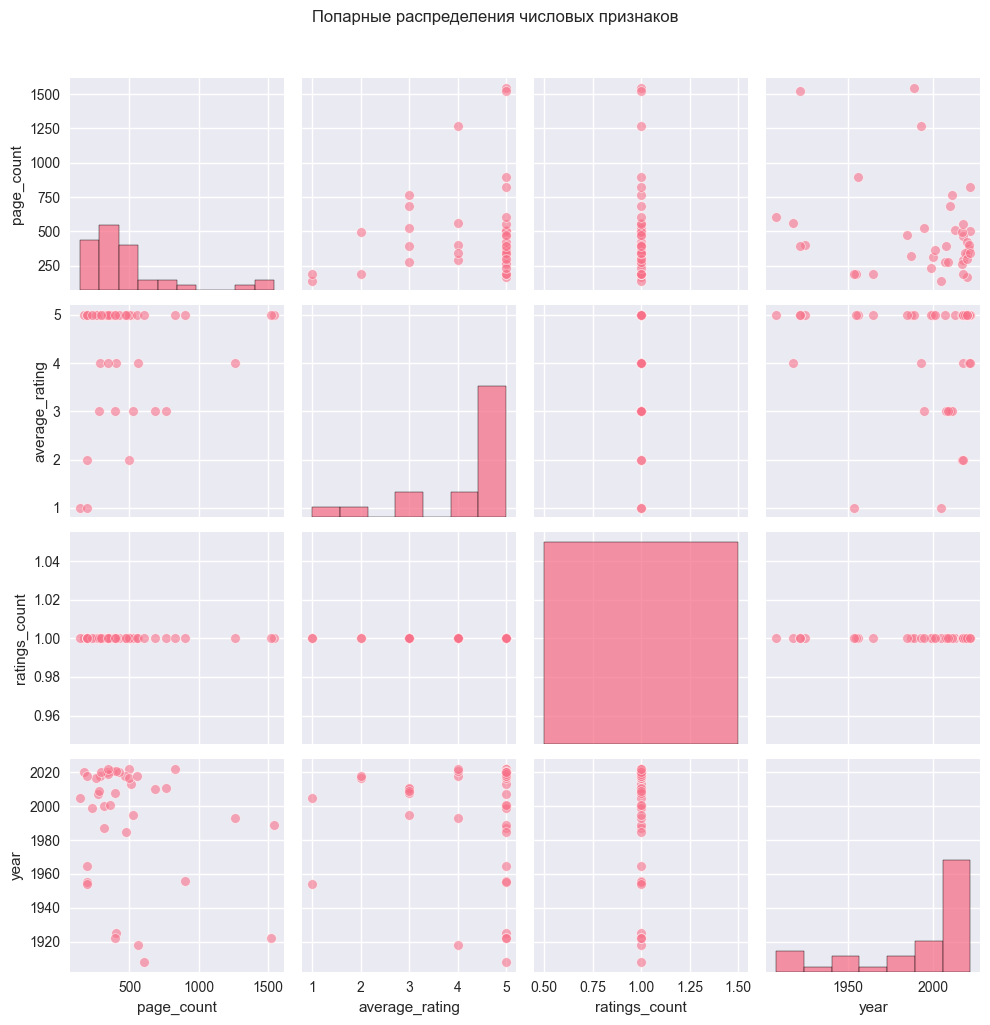

In [38]:
numeric_cols_for_pairplot = ['page_count', 'average_rating', 'ratings_count', 'year']
available_numeric = [col for col in numeric_cols_for_pairplot if col in df.columns and df[col].notna().sum() > 10]

if len(available_numeric) >= 2:
    pairplot_data = df[available_numeric].dropna()
    if len(pairplot_data) > 0:
        sns.pairplot(pairplot_data, diag_kind='hist', plot_kws={'alpha': 0.6})
        plt.suptitle('Попарные распределения числовых признаков', y=1.02)
        plt.tight_layout()
        plt.show()
    else:
        print("Недостаточно данных для построения попарных распределений.")
else:
    print("Недостаточно числовых признаков для попарных распределений.")


## 10. Сводные таблицы

In [39]:
print("Сводная таблица по источникам данных:\n")
if 'source' in df.columns:
    summary_by_source = df.groupby('source').agg({
        'title': 'count',
        'author': lambda x: x.notna().sum(),
        'description': lambda x: x.notna().sum(),
        'average_rating': lambda x: x.notna().sum(),
        'page_count': lambda x: x.notna().sum(),
        'year': lambda x: x.notna().sum()
    }).rename(columns={
        'title': 'Всего книг',
        'author': 'С автором',
        'description': 'С описанием',
        'average_rating': 'С рейтингом',
        'page_count': 'С количеством страниц',
        'year': 'С годом'
    })
    print(summary_by_source)

print("\n" + "="*60)
print("Сводная таблица по языкам:\n")
if 'language' in df.columns:
    lang_summary = df['language'].value_counts().head(10)
    print(lang_summary)

print("\n" + "="*60)
print("Сводная таблица по категориям (топ-10):\n")
if 'categories' in df.columns:
    all_categories = []
    for cats in df['categories'].dropna():
        if isinstance(cats, str):
            all_categories.extend([c.strip() for c in cats.split(',')])
    cat_counts = pd.Series(all_categories).value_counts().head(10)
    print(cat_counts)


Сводная таблица по источникам данных:

                   Всего книг  С автором  С описанием  С рейтингом  \
source                                                               
google_books_api         1732       1381          946           52   
project_gutenberg       10000       9632            0            0   

                   С количеством страниц  С годом  
source                                             
google_books_api                    1681     1530  
project_gutenberg                      0        0  

Сводная таблица по языкам:

language
en       1660
ru         69
de          2
ko          1
zh-CN       1
Name: count, dtype: int64

Сводная таблица по категориям (топ-10):

Fiction                        427
Literary Criticism              71
Biography & Autobiography       38
History                         32
Language Arts & Disciplines     32
Juvenile Fiction                31
American literature             27
Science fiction                 22
Education       

## 11. Анализ текстовых данных (описания)

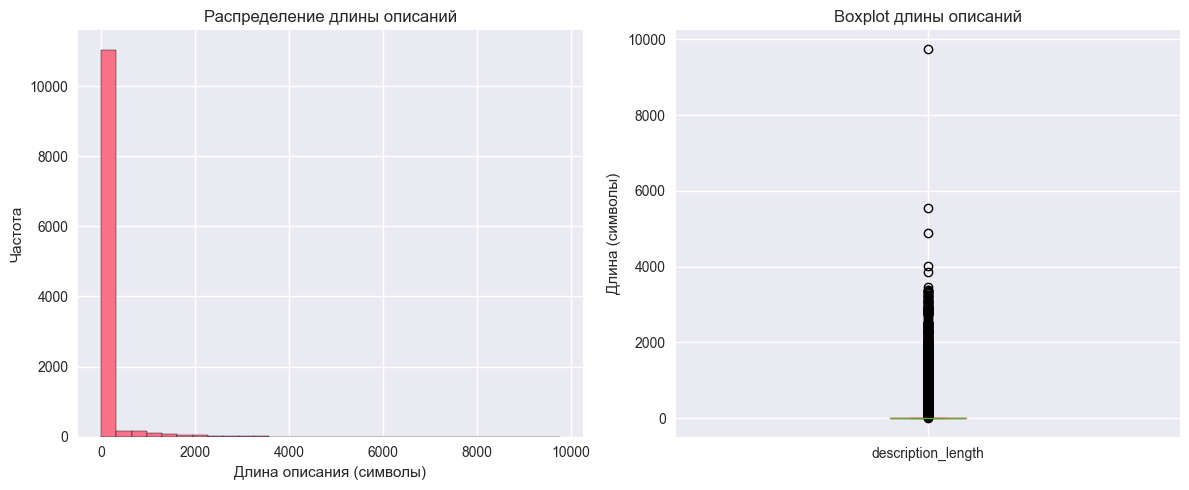

Средняя длина описания: 80 символов
Медианная длина описания: 0 символов


In [40]:
if 'description' in df.columns:
    df['description_length'] = df['description'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    df['description_length'].hist(bins=30, edgecolor='black')
    plt.title('Распределение длины описаний')
    plt.xlabel('Длина описания (символы)')
    plt.ylabel('Частота')
    
    plt.subplot(1, 2, 2)
    df['description_length'].plot(kind='box')
    plt.title('Boxplot длины описаний')
    plt.ylabel('Длина (символы)')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Средняя длина описания: {df['description_length'].mean():.0f} символов")
    print(f"Медианная длина описания: {df['description_length'].median():.0f} символов")


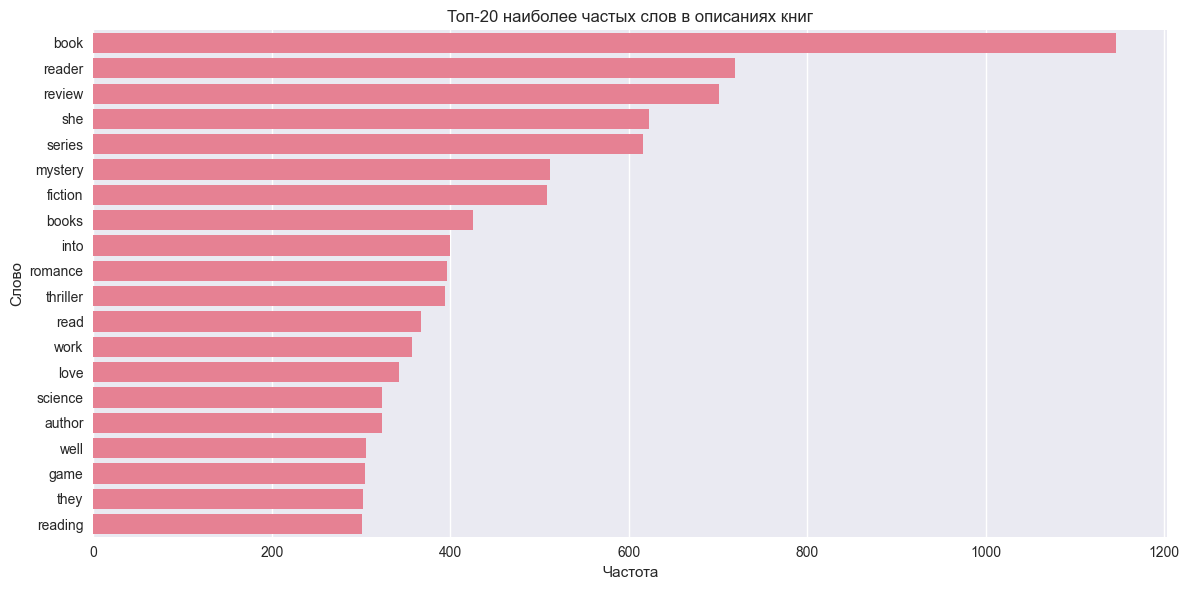


Всего уникальных слов: 13726
Топ-10 слов:
  book: 1146
  reader: 719
  review: 701
  she: 623
  series: 616
  mystery: 512
  fiction: 509
  books: 425
  into: 400
  romance: 396


In [41]:
if 'description' in df.columns:
    all_text = ' '.join(df['description'].dropna().astype(str))
    
    words = re.findall(r'\b[a-zA-Z]{3,}\b', all_text.lower())
    
    stop_words = {'the', 'and', 'for', 'are', 'but', 'not', 'you', 'all', 'can', 'her', 'was', 'one', 'our', 'out', 'day', 'get', 'has', 'him', 'his', 'how', 'its', 'may', 'new', 'now', 'old', 'see', 'two', 'who', 'way', 'use', 'man', 'men', 'had', 'this', 'that', 'with', 'from', 'have', 'been', 'will', 'more', 'than', 'their', 'what', 'when', 'where', 'which', 'while', 'would', 'could', 'should'}
    words = [w for w in words if w not in stop_words]
    
    word_counts = Counter(words)
    top_words = word_counts.most_common(20)
    
    words_df = pd.DataFrame(top_words, columns=['Слово', 'Частота'])
    plt.figure(figsize=(12, 6))
    sns.barplot(data=words_df, x='Частота', y='Слово')
    plt.title('Топ-20 наиболее частых слов в описаниях книг')
    plt.xlabel('Частота')
    plt.ylabel('Слово')
    plt.tight_layout()
    plt.show()
    
    print(f"\nВсего уникальных слов: {len(word_counts)}")
    print(f"Топ-10 слов:")
    for word, count in top_words[:10]:
        print(f"  {word}: {count}")


## 12. Выводы

In [42]:
print("1. Объем данных")
print(f"Всего записей: {len(df)}")
print(f"Из Google Books API: {len(df[df['source'] == 'google_books_api'])}")
print(f"Из Project Gutenberg: {len(df[df['source'] == 'project_gutenberg'])}")
print()

print("2. Целевая переменная metadata_completeness")
if 'metadata_completeness' in df.columns:
    completeness_counts = df['metadata_completeness'].value_counts()
    for status, count in completeness_counts.items():
        pct = count / len(df) * 100
        print(f"{status}: {count} книг ({pct:.1f}%)")
print()

print("3. Пропущенные значения")
missing_summary = df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
print("Наиболее проблемные колонки:")
for col, count in missing_summary.head(5).items():
    pct = (count / len(df)) * 100
    print(f"{col}: {count} ({pct:.1f}%)")
total_missing = df.isnull().sum().sum()
total_cells = len(df) * len(df.columns)
sparsity = (total_missing / total_cells) * 100
print(f"Общая разреженность датасета: {sparsity:.2f}%")
print()

if 'average_rating' in df.columns:
    avg_rating = df['average_rating'].dropna()
    if len(avg_rating) > 0:
        print("4. Статистика по рейтингам")
        print(f"Средний рейтинг: {avg_rating.mean():.2f}")
        print(f"Медианный рейтинг: {avg_rating.median():.2f}")
        print(f"Книг с рейтингом: {len(avg_rating)} ({len(avg_rating)/len(df)*100:.1f}%)")
        print("Рейтинги доступны только для книг из Google Books API")
        print()

if 'ratings_count' in df.columns:
    ratings_count = df['ratings_count'].dropna()
    if len(ratings_count) > 0:
        print("5. Количество оценок")
        print(f"Среднее: {ratings_count.mean():.0f}")
        print(f"Медиана: {ratings_count.median():.0f}")
        print(f"Книг с оценками: {len(ratings_count)} ({len(ratings_count)/len(df)*100:.1f}%)")
        print()

if 'page_count' in df.columns:
    page_count = df['page_count'].dropna()
    if len(page_count) > 0:
        print("6. Количество страниц")
        print(f"Среднее: {page_count.mean():.0f}")
        print(f"Медиана: {page_count.median():.0f}")
        print(f"Диапазон: {page_count.min():.0f} - {page_count.max():.0f}")
        print()

if 'year' in df.columns:
    year = df['year'].dropna()
    if len(year) > 0:
        print("7. Годы публикации")
        print(f"Средний год: {year.mean():.0f}")
        print(f"Медианный год: {year.median():.0f}")
        print(f"Диапазон: {year.min():.0f} - {year.max():.0f}")
        print()
        

1. Объем данных
Всего записей: 11733
Из Google Books API: 1733
Из Project Gutenberg: 10000

2. Целевая переменная metadata_completeness
incomplete: 10857 книг (92.5%)
complete: 876 книг (7.5%)

3. Пропущенные значения
Наиболее проблемные колонки:
ratings_count: 11689 (99.6%)
average_rating: 11681 (99.6%)
publisher: 10976 (93.5%)
description: 10787 (91.9%)
categories: 10369 (88.4%)
Общая разреженность датасета: 59.32%

4. Статистика по рейтингам
Средний рейтинг: 4.33
Медианный рейтинг: 5.00
Книг с рейтингом: 52 (0.4%)
Рейтинги доступны только для книг из Google Books API

5. Количество оценок
Среднее: 1
Медиана: 1
Книг с оценками: 44 (0.4%)

6. Количество страниц
Среднее: 415
Медиана: 327
Диапазон: 0 - 1586

7. Годы публикации
Средний год: 1987
Медианный год: 2005
Диапазон: 1900 - 2026

